In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==3.3.0

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType

spark = SparkSession.builder \
    .appName("Spark NLP") \
    .master("local[8]") \
    .config("spark.driver.memory","12G") \
    .config("spark.driver.maxResultSize", "2G") \
    .config('spark.ui.port', '4050')\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "800M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.0") \
    .getOrCreate()

print(spark.sparkContext._conf.getAll())

[('spark.driver.port', '46069'), ('spark.driver.maxResultSize', '2G'), ('spark.app.startTime', '1639156411491'), ('spark.driver.host', '171f939cd9ea'), ('spark.files', 'file:///root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-3.3.0.jar,file:///root/.ivy2/jars/com.typesafe_config-1.4.1.jar,file:///root/.ivy2/jars/org.rocksdb_rocksdbjni-6.5.3.jar,file:///root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.603.jar,file:///root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,file:///root/.ivy2/jars/com.navigamez_greex-1.0.jar,file:///root/.ivy2/jars/org.json4s_json4s-ext_2.12-3.5.3.jar,file:///root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.3.3.jar,file:///root/.ivy2/jars/net.sf.trove4j_trove4j-3.0.3.jar,file:///root/.ivy2/jars/com.google.code.findbugs_annotations-3.0.1.jar,file:///root/.ivy2/jars/com.google.protobuf_protobuf-java-util-3.0.0-beta-3.jar,file:///root/.ivy2/jars/com.google.protobuf_protobuf-java-3.0.0-beta-3.jar,file:///root/.ivy2/jars/it.un

#### Processing

In [ ]:
spark.sql("CREATE TEMPORARY VIEW PERSON USING parquet OPTIONS (path \"/content/drive/MyDrive/datasets/Twitter_data/all_tweets_11212021-145035.parquet\")")
#spark.sql("SELECT samp_id FROM PERSON LIMIT 2").show()

df= spark.sql("SELECT samp_id, org_text FROM PERSON")
df.show(3, False)

+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|samp_id            |org_text                                                                                                                                                                                                                                                                                                |
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1451861522431496196|#2. Don't Hire the Fir

In [ ]:
#no of partitions:
print(df.rdd.getNumPartitions())
df= df.repartition(8)
print(df.rdd.getNumPartitions())

1
8


In [ ]:
from pyspark.sql import functions as F
from sparknlp.base import *
from sparknlp.annotator import *

In [ ]:
df2= df.limit(100).persist()
df2= df.repartition(8).persist()
#replace &amp or &gt etc with and
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "&\w+", "and"))
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "—", " "))
#replace links
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "(http:[/\w.]+|https:[/\w.]+)", ""))
#replace user mentions
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "@[\w.]+", ""))
#replace hashtags
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "#\w+", ""))
df2= df2.withColumn('org_text', F.regexp_replace(F.col("org_text"), "\s{2,}", " ")).persist()

In [ ]:
df2.show(10, False)

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|samp_id            |org_text                                                                                                                                                                                                                                                                 |
+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1451367585694498818|Interested in ecological urban design and making cities better for biodiversity to thrive? Check out some roles my 

In [ ]:
documentAssembler = DocumentAssembler().setInputCol("org_text").setOutputCol("document").setCleanupMode("shrink")

sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized").setLowercase(True)\
                         .setCleanupPatterns(["""[^\w\d\s]"""]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
  
stopwords_cleaner = StopWordsCleaner().setInputCols("normalized").setOutputCol("cleanTokens").setCaseSensitive(False)

lemmatizer = Lemmatizer() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma") \
    .setDictionary("/content/drive/MyDrive/Pretrained_models/AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")

spellModel = ContextSpellCheckerModel\
    .load("/content/drive/MyDrive/Pretrained_models/spellcheck_dl_en_3.0.0_3.0_1616900699393")\
    .setInputCols("lemma")\
    .setOutputCol("spell_checked")

pos = PerceptronModel.load("/content/drive/MyDrive/Pretrained_models/pos_anc_en_3.0.0_3.0_1614962126490/")\
      .setInputCols("document","spell_checked")\
      .setOutputCol("pos")
      
tokenassembler = TokenAssembler()\
    .setInputCols(["document","spell_checked"]) \
    .setOutputCol("clean_text")

In [ ]:
nlpPipeline = Pipeline(stages=[
    documentAssembler,
    #sentenceDetector, 
    tokenizer,
    normalizer,
    stopwords_cleaner,
    lemmatizer,
    spellModel,
    pos
 ])

In [ ]:
df3 = nlpPipeline.fit(df2).transform(df2)
df3.rdd.getNumPartitions()

8

In [ ]:
#df3.show(10, False)

In [ ]:
#df4= df3.limit(10)
result_df = df3.select(F.col('samp_id'),F.col('document'), F.col('spell_checked'),\
                       F.explode(F.arrays_zip(F.col('cleanTokens.result').alias('clean_tokens'),  F.col('lemma.result').alias('lemma_tokens'), \
                                F.col('spell_checked.result').alias('spell_tokens'), F.col('pos.result').alias('pos_tokens'))).alias("cols")) \
                                .select(F.col('samp_id'), F.col('document'), F.col('spell_checked'),F.col("cols.clean_tokens").alias("cleanTokens"), \
                    F.col("cols.lemma_tokens").alias("lemma_result"), \
                    F.col("cols.spell_tokens").alias("spell_checked_result"), \
                    F.col("cols.pos_tokens").alias("pos_result"))

In [ ]:
final_df= result_df.filter(result_df.pos_result.isin(['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS','NNPS']))
assembled_df= tokenassembler.transform(final_df).select('samp_id', 'clean_text').persist()
#print(assembled_df.count())
assembled_df_unique= assembled_df.dropDuplicates(['samp_id'])

In [ ]:
#assembled_df_unique.count()

In [ ]:
assembled_df_unique.columns

['samp_id', 'clean_text']

In [ ]:
#df= assembled_df_unique.withColumn('clean_text.result', reg_replaceUdf(F.col('clean_text.result')))
common_terms= ["hire", "recruitment", "now", "look", "apply", "work", "job", "position", "interest", "application", "program", "people", "make", "take", "team"]
df= assembled_df_unique.withColumn('tweet_text', F.regexp_replace(F.col("clean_text.result"), "hire", "")).drop('clean_text')
df= df.withColumn('tweet_text', F.regexp_replace(F.col("tweet_text"), "recruitment", ""))

In [ ]:
df.show(2, False)

### Word Cloud:

In [ ]:
#final_df_pandas= df.coalesce(1).select('samp_id', 'tweet_text').toPandas()

In [ ]:
#assembled_df_unique.printSchema()

In [ ]:
#final_df3= assembled_df_unique.select('samp_id',  F.explode('clean_text.result'))
final_df3= df.select('samp_id',  F.explode('tweet_text'))

In [ ]:
text_blob= final_df3.agg(F.concat_ws(" ",F.collect_list(F.col("col.result")))).first()[0]

(-0.5, 399.5, 199.5, -0.5)

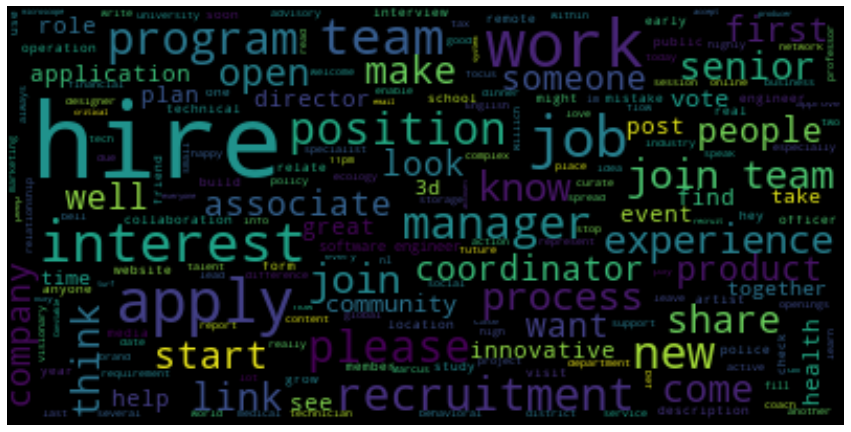

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

#mask = np.array(Image.open("filepath/image.png"))
plt.figure(figsize=(15,9))
wordcloud = WordCloud(max_font_size=50, max_words=500, #mask=mask,
                      background_color="black").generate(text_blob)
default_colors = wordcloud.to_array() #convert to array for recoloring
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

#wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=500)\
#.generate_from_frequencies(data['document_biden_2021'])

### For reference for POS tagging:

In [ ]:
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pos_df= pd.read_html('https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html')

pos_df[0]

,0,1,2
0,Number,Tag,Description
1,1.,CC,Coordinating conjunction
2,2.,CD,Cardinal number
3,3.,DT,Determiner
4,4.,EX,Existential there
5,5.,FW,Foreign word
6,6.,IN,Preposition or subordinating conjunction
7,7.,JJ,Adjective
8,8.,JJR,"Adjective, comparative"
9,9.,JJS,"Adjective, superlative"
